# Compact Programming Language Detectors
<hr>

## Approaches:
* ### Relying only on source code
Guesslang - has a neural networks (machine learning) based approach
* ### Using source file information
Linguist, Polyglot

## Detectors used for analysis:
* ### Guesslang
https://github.com/yoeo/guesslang
* ### Polyglot
https://github.com/pranavbaburaj/polyglot

## Basis of comparison
* ### Time
* ### Accuracy
* ### Memory

In [5]:
# install required packages
import sys
!{'"'+(sys.executable)+'"'} -m pip install numpy
!{'"'+(sys.executable)+'"'} -m pip install matplotlib
!{'"'+(sys.executable)+'"'} -m pip install guesslang
!{'"'+(sys.executable)+'"'} -m pip install python-polyglot

In [21]:
# import libraries
import os
import numpy as np
from polyglot.core import Polyglot
from guesslang import Guess
import matplotlib.pyplot as plt
from time import process_time_ns

## Test dataset
* Contains source codes in 8 languages.
* Has 10 files for each language.
* Files are picked from open source repositories on github

In [22]:
# list of languages
langs = ["python", 'c', 'cpp', 'java', 'javascript', 'html', 'css', 'typescript']

In [15]:
# uncomment and run only if test dataset is not already prepared
# Code for making directories for test dataset

# for l in langs:
#     for i in range(10):
#         try:
#             os.mkdir("./data/"+ l + str(i+1))
#         except FileExistsError:
#             break

In [16]:
# Helper functions

def read_file(directory):
    """
    Function for reading code from source file
    """
    files = os.listdir(directory)
    if len(files) != 1:
        return ""
    file = files[0]
    f = open(directory + "/" + file, "r")
    source_code = f.read()
    f.close()
    return source_code

def update_conf_matrix(conf, actual, predicted):
    """
    Function for updating confusion matrix
    """
    predicted = predicted.lower()
    if predicted == "c++":
        predicted = "cpp"
    if predicted in langs:
        conf[langs.index(actual)][langs.index(predicted)] += 1
    else:
        conf[langs.index(actual)][len(langs)] += 1

## Guesslang
* Neural network implemented using tensorflow.
* Performs forward propagation on trained model to predict language.

## Polyglot
* Looks up language for filename extension in a language detection file (languages.yaml)
* Creates object for all files in a directory and computes percentage of each language in the directory.

In [25]:
# Initialize confusion matrices and arrays to store execution time
conf_guess = np.zeros((len(langs), len(langs)+1))
conf_pgt = np.zeros((len(langs), len(langs)+1))
time_guess = np.zeros((len(langs), 10))
time_pgt = np.zeros((len(langs), 10))

guess = Guess()

for l in langs:
    for i in range(10):
        print(l, i)
        dirname = "./data/" + l + str(i+1)
        
        # use guseslang to detect language
        source_code = read_file(dirname)
        if source_code == "":
            lang_name = "None"
        else:
            start = process_time_ns()
            lang_name = guess.language_name(source_code)
            end = process_time_ns()
        print("\tguesslang:", lang_name)
        time_guess[langs.index(l)][i] = end - start
        update_conf_matrix(conf_guess, l, lang_name)
        
        # use polyglot to detect language
        polyglot = Polyglot(dirname)
        start = process_time_ns()
        stats = polyglot.show(display=False) ['files']
        end = process_time_ns()
        try:
            lang_name = max(stats, key = lambda x: stats[x]['total'])
        except ValueError:
            lang_name = "None"
        print("\tpolyglot :", lang_name)
        time_pgt[langs.index(l)][i] = end - start
        update_conf_matrix(conf_pgt, l, lang_name)

python 0
	guesslang: Python
	polyglot : Python
python 1
	guesslang: Python
	polyglot : Python
python 2
	guesslang: Python
	polyglot : Python
python 3
	guesslang: Python
	polyglot : Python
python 4
	guesslang: Python
	polyglot : Python
python 5
	guesslang: Python
	polyglot : Python
python 6
	guesslang: Python
	polyglot : Python
python 7
	guesslang: Python
	polyglot : Python
python 8
	guesslang: Python
	polyglot : Python
python 9
	guesslang: Python
	polyglot : Python
c 0
	guesslang: C
	polyglot : C
c 1
	guesslang: C++
	polyglot : C
c 2
	guesslang: C++
	polyglot : C
c 3
	guesslang: C
	polyglot : C
c 4
	guesslang: C
	polyglot : C
c 5
	guesslang: C
	polyglot : C
c 6
	guesslang: C
	polyglot : C
c 7
	guesslang: C
	polyglot : C
c 8
	guesslang: C
	polyglot : C
c 9
	guesslang: C
	polyglot : C
cpp 0
	guesslang: C++
	polyglot : C++
cpp 1
	guesslang: C++
	polyglot : C++
cpp 2
	guesslang: C++
	polyglot : C++
cpp 3
	guesslang: C++
	polyglot : C++
cpp 4
	guesslang: C++
	polyglot : C++
cpp 5
	guesslang

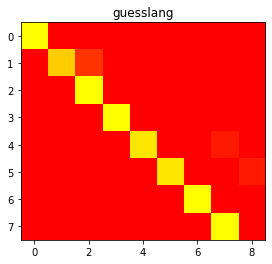

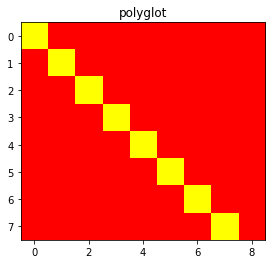

[[10.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  8.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  9.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  9.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.]]

[[10.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.]]

[[1.8750e+08 0.0000e+00 0.0000e+00 0.0000e+00 1.5625e+07 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 1.5625e+07]
 [1.5625e+07 1.5625e+07 3.1250e+07 1.5625e+07 1.5625e+07 1.5625e+07
  1.5625e+07 1.5625e+07 1.5625e+07 3.1250e+07]
 [0.0000e+00 3.1250e+07 4.6875e+07 0.0000e+00 0.0000e+00 1.5625e+07
  1.5625e+07 3.1250e+07 0.0000e+00 1.5625e+07]
 [1.5625e+07 1.5625e+07 0.0

In [28]:
plt.imshow(conf_guess, cmap = 'autumn', interpolation = 'nearest')
plt.title("guesslang")
plt.show()
plt.imshow(conf_pgt, cmap = 'autumn', interpolation = 'nearest')
plt.title("polyglot")
plt.show()
print(conf_guess)
print()
print(conf_pgt)
print()
print(time_guess)
print()
print(time_pgt)

## Limitations
### Guesslang
* Confuses languages with similar syntax: (C, C++) and (JavaScript, TypeScript)

### Polyglot
* Will falter if file extensions are not given or incorrect.

## My solution
* Learn feature set for languages through training set
* Feature set should contain: 
    * Frequency of characters other than letters and digits (,.-_/#$% etc.)
    * List of commonly occuring keywords of the language
* Compares test source code with feature library and returns the language which matches the most.